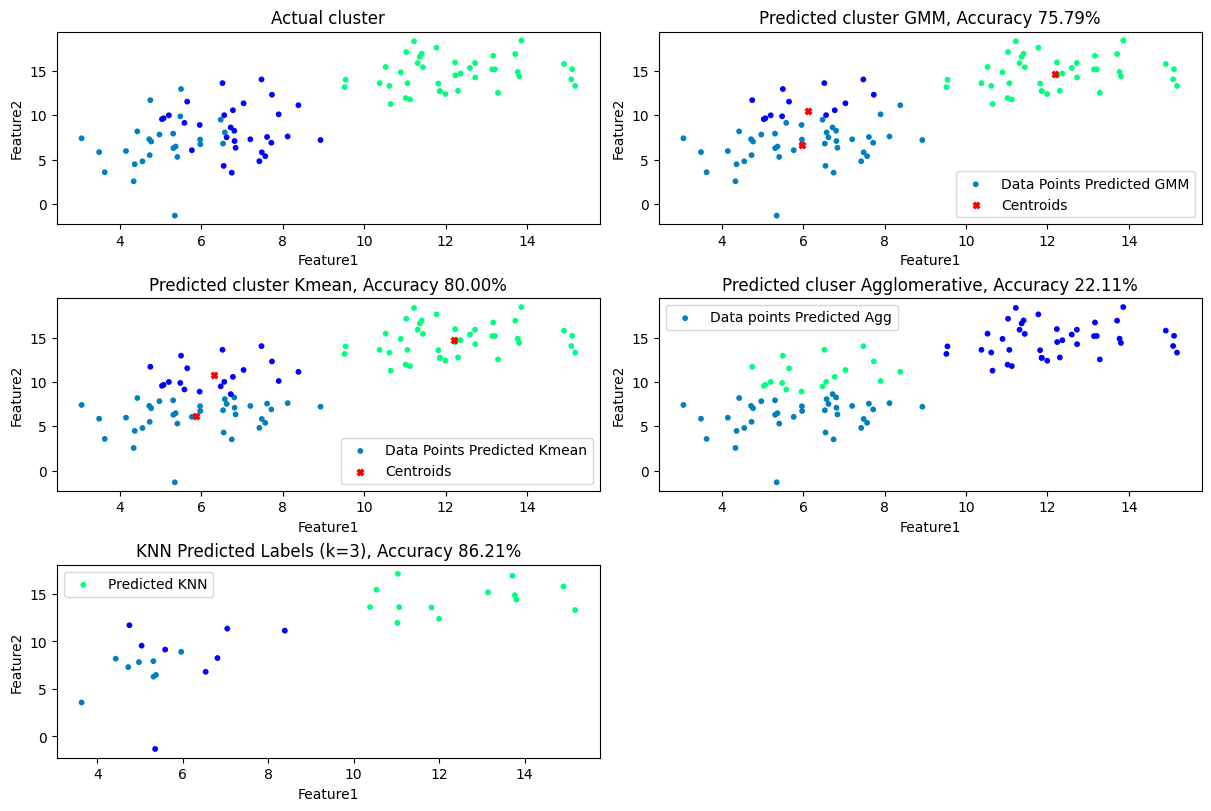

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


mu1, sigma1 = [7, 9], [[1, -0.5], [-0.5, 10]]
mu2, sigma2 = [5, 7], [[1, 0.5], [0.5, 10]]
mu3, sigma3 = [12, 15], [[2, 0.8], [0.8, 4]]

# Generate synthetic data
np.random.seed(42)
cluster1 = np.random.multivariate_normal(mu1, sigma1, size=30)
label1 = np.full((cluster1.shape[0], 1), '0')
cluster1_with_label = np.hstack((cluster1, label1))

cluster2 = np.random.multivariate_normal(mu2, sigma2, size=25)
label2 = np.full((cluster2.shape[0], 1), '1')
cluster2_with_label = np.hstack((cluster2, label2))

cluster3 = np.random.multivariate_normal(mu3, sigma3, size=40)
label3 = np.full((cluster3.shape[0], 1), '2')
cluster3_with_label = np.hstack((cluster3, label3))

combined_data = np.vstack((cluster1_with_label, cluster2_with_label, cluster3_with_label))
np.random.shuffle(combined_data)

df = pd.DataFrame(combined_data, columns=['Feature1', 'Feature2', 'label_true'])
X = df[['Feature1', 'Feature2']].astype(float)
y_true = df['label_true'].values.astype(int)

# Fit GMM
gmm = GaussianMixture(n_components=3, random_state=42)
gmm.fit(X)

# Predict cluster labels
y_predicted_gmm = gmm.predict(X)
df['Predicted Label GMM'] = y_predicted_gmm


kmeans = KMeans(n_clusters=3, random_state=42)
y_predicted_kmeans = kmeans.fit_predict(X)
df['Predicted Label KMeans'] = y_predicted_kmeans


agg_cluster = AgglomerativeClustering(n_clusters=3, linkage='ward')
y_predicted_agg = agg_cluster.fit_predict(X)
df['Predicted Label Agglomerative'] = y_predicted_agg


X_train, X_test, y_train, y_test = train_test_split(X, y_true, test_size=0.3, random_state=42)

# Train the KNN Classifier
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
y_predicted_KNN = knn.predict(X_test)


accuracy_gmm = accuracy_score(y_true, y_predicted_gmm)
accuracy_kmeans = accuracy_score(y_true, y_predicted_kmeans)
accuracy_agg = accuracy_score(y_true, y_predicted_agg)
accuracy_knn = accuracy_score(y_test, y_predicted_KNN)

# Plot the results
fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(12, 8), layout="constrained")

# Scatter plot for True Labels
axs[0,0].scatter(X['Feature1'].values, X['Feature2'].values, c=y_true, cmap='winter', s=10, label="Data Points")
axs[0,0].set_title("Actual cluster")
axs[0,0].set_xlabel("Feature1")
axs[0,0].set_ylabel("Feature2")


# Scatter plot for Predicted Labels
axs[0,1].scatter(X['Feature1'].values, X['Feature2'].values, c=y_predicted_gmm, cmap='winter', s=10, label="Data Points Predicted GMM")

# GMM cluster centers
axs[0,1].scatter(gmm.means_[:, 0], gmm.means_[:, 1], c='red', s=20, marker='X', label="Centroids")
axs[0,1].set_title(f"Predicted cluster GMM, Accuracy {accuracy_gmm * 100:.2f}%")
axs[0,1].set_xlabel("Feature1")
axs[0,1].set_ylabel("Feature2")
axs[0,1].legend()

# Scatter plot for Predicted Labels
axs[1,0].scatter(X['Feature1'].values, X['Feature2'].values, c=y_predicted_kmeans, cmap='winter', s=10, label="Data Points Predicted Kmean")

# GMM cluster centers
axs[1,0].scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', s=20, marker='X', label="Centroids")
axs[1,0].set_title(f"Predicted cluster Kmean, Accuracy {accuracy_kmeans * 100:.2f}%")
axs[1,0].set_xlabel("Feature1")
axs[1,0].set_ylabel("Feature2")
axs[1,0].legend()

axs[1,1].scatter(X['Feature1'].values, X['Feature2'].values, c=y_predicted_agg, cmap='winter', s=10, label='Data points Predicted Agg')
axs[1,1].set_title(f"Predicted cluser Agglomerative, Accuracy {accuracy_agg * 100:.2f}%")
axs[1,1].set_xlabel("Feature1")
axs[1,1].set_ylabel("Feature2")
axs[1,1].legend()

# Predicted labels
axs[2,0].scatter(X_test['Feature1'].values, X_test['Feature2'].values, c=y_predicted_KNN, cmap='winter', s=10, label='Predicted KNN')
axs[2,0].set_title(f"KNN Predicted Labels (k={3}), Accuracy {accuracy_knn * 100:.2f}%")
axs[2,0].set_xlabel("Feature1")
axs[2,0].set_ylabel("Feature2")
axs[2,0].legend()

axs[2,1].set_axis_off()

plt.show()


GMM from scratch

Converged at iteration 49


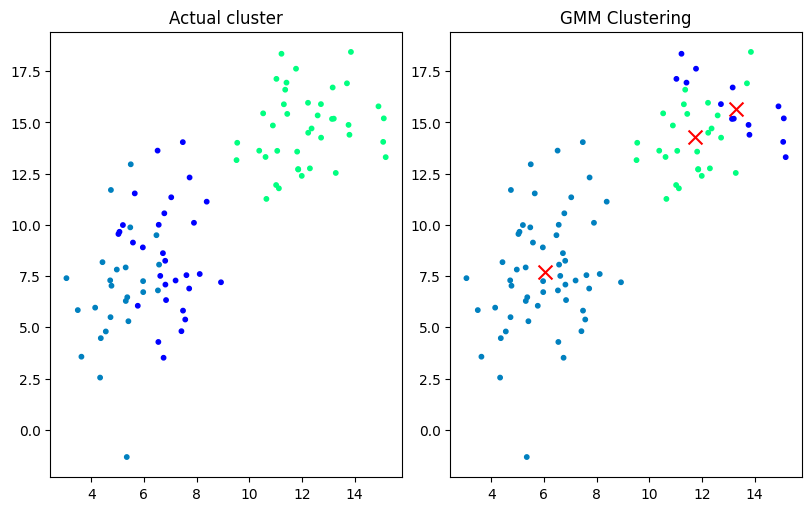

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Gaussian PDF
def gaussian_pdf(x, mean, cov):
    d = len(mean)
    cov_inv = np.linalg.inv(cov)
    det_cov = np.linalg.det(cov)
    norm_const = 1.0 / (np.power((2 * np.pi), d / 2) * np.sqrt(det_cov))
    diff = x - mean
    return norm_const * np.exp(-0.5 * np.dot(np.dot(diff.T, cov_inv), diff))

# GMM Class
class GMM:
    def __init__(self, n_components, max_iters=100, tol=1e-6):
        self.n_components = n_components  # Number of clusters
        self.max_iters = max_iters        # Maximum iterations
        self.tol = tol                    # Convergence threshold
        
    def initialize_parameters(self, X):
        n_samples, n_features = X.shape
        
        # Randomly initialize means
        self.means = X[np.random.choice(n_samples, self.n_components, replace=False)]
        
        # Initialize covariance matrices to identity
        self.covariances = [np.eye(n_features) for _ in range(self.n_components)]
        
        # Initialize mixing coefficients equally
        self.mixing_coeffs = np.ones(self.n_components) / self.n_components
        
    def e_step(self, X):
        n_samples = X.shape[0]
        self.responsibilities = np.zeros((n_samples, self.n_components))
        
        # Calculate responsibilities (gamma_ik)
        for i in range(n_samples):
            for k in range(self.n_components):
                self.responsibilities[i, k] = (
                    self.mixing_coeffs[k] * gaussian_pdf(X[i], self.means[k], self.covariances[k])
                )
            # Normalize responsibilities across all components
            self.responsibilities[i, :] /= np.sum(self.responsibilities[i, :])
    
    def m_step(self, X):
        n_samples, n_features = X.shape
        weights = np.sum(self.responsibilities, axis=0)  # Sum of responsibilities for each component
        
        # Update means
        self.means = np.zeros((self.n_components, n_features))
        for k in range(self.n_components):
            self.means[k] = np.sum(self.responsibilities[:, k, np.newaxis] * X, axis=0) / weights[k]
        
        # Update covariances
        self.covariances = []
        for k in range(self.n_components):
            cov = np.zeros((n_features, n_features))
            for i in range(n_samples):
                diff = (X[i] - self.means[k]).reshape(-1, 1)
                cov += self.responsibilities[i, k] * np.dot(diff, diff.T)
            self.covariances.append(cov / weights[k])
        
        # Update mixing coefficients
        self.mixing_coeffs = weights / n_samples
    
    def compute_log_likelihood(self, X):
        n_samples = X.shape[0]
        log_likelihood = 0
        for i in range(n_samples):
            temp = 0
            for k in range(self.n_components):
                temp += self.mixing_coeffs[k] * gaussian_pdf(X[i], self.means[k], self.covariances[k])
            log_likelihood += np.log(temp)
        return log_likelihood
    
    def fit(self, X):
        self.initialize_parameters(X)
        log_likelihood_old = 0
        
        for iteration in range(self.max_iters):
            # E-step
            self.e_step(X)
            
            # M-step
            self.m_step(X)
            
            # Check convergence
            log_likelihood_new = self.compute_log_likelihood(X)
            if np.abs(log_likelihood_new - log_likelihood_old) < self.tol:
                print(f"Converged at iteration {iteration}")
                break
            log_likelihood_old = log_likelihood_new
    
    def predict(self, X):
        n_samples = X.shape[0]
        cluster_assignments = np.zeros(n_samples, dtype=int)
        
        for i in range(n_samples):
            probabilities = [
                self.mixing_coeffs[k] * gaussian_pdf(X[i], self.means[k], self.covariances[k])
                for k in range(self.n_components)
            ]
            cluster_assignments[i] = np.argmax(probabilities)
        return cluster_assignments

# Generate synthetic data
# from sklearn.datasets import make_blobs

# X, y_true = make_blobs(n_samples=300, centers=3, cluster_std=1.0, random_state=42)

# Generate synthetic data

mu1, sigma1 = [7, 9], [[1, -0.5], [-0.5, 10]]
mu2, sigma2 = [5, 7], [[1, 0.5], [0.5, 10]]
mu3, sigma3 = [12, 15], [[2, 0.8], [0.8, 4]]


np.random.seed(42)
cluster1 = np.random.multivariate_normal(mu1, sigma1, size=30)
label1 = np.full((cluster1.shape[0], 1), '0')
cluster1_with_label = np.hstack((cluster1, label1))

cluster2 = np.random.multivariate_normal(mu2, sigma2, size=25)
label2 = np.full((cluster2.shape[0], 1), '1')
cluster2_with_label = np.hstack((cluster2, label2))

cluster3 = np.random.multivariate_normal(mu3, sigma3, size=40)
label3 = np.full((cluster3.shape[0], 1), '2')
cluster3_with_label = np.hstack((cluster3, label3))

combined_data = np.vstack((cluster1_with_label, cluster2_with_label, cluster3_with_label))
np.random.shuffle(combined_data)

df = pd.DataFrame(combined_data, columns=['Feature1', 'Feature2', 'label_true'])
X = df[['Feature1', 'Feature2']].values.astype(float)
y_true = df['label_true'].values.astype(int)

# Fit GMM
gmm = GMM(n_components=3)
gmm.fit(X)

# Predict clusters
y_pred = gmm.predict(X)

# Visualize results

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(8, 5), layout="constrained")

# Scatter plot for True Labels
axs[0].scatter(X[:, 0], X[:, 1], c=y_true, cmap='winter', s=10)
axs[0].set_title("Actual cluster")

axs[1].scatter(X[:, 0], X[:, 1], c=y_pred, cmap='winter', s=10)
axs[1].scatter(gmm.means[:, 0], gmm.means[:, 1], c='red', s=100, marker='x')  # Plot means
axs[1].set_title("GMM Clustering")
plt.show()
